In [8]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import load, dump

from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, precision_score, make_scorer, recall_score, f1_score, roc_curve, roc_auc_score,accuracy_score,classification_report

In [2]:
# data=pd.read_csv(r'C:\Users\azad.aliyev\Downloads\data.csv')

In [5]:
data=pd.read_csv(r'C:\Users\Asus\Downloads\Thesis\dataset\data.csv')

In [128]:
sampled_data = data.sample(n=10000, random_state=42)

X = sampled_data.drop(columns=['anomaly'])
y = sampled_data['anomaly']

# Step 1: Prepare sampled data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [2]:
# from google.colab import drive
# drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# data = pd.read_csv('/content/drive/My Drive/thesis/data.csv')

In [3]:
sampled_data = data.sample(n=100000, random_state=42)

In [47]:
# Function to predict on a data chunk using a single model
def predict_on_chunk(data_chunk, model):
    return model.predict(data_chunk)  # -1 = anomaly, 1 = normal

# Split the test dataset into chunks
test_chunks = np.array_split(X_test, 8)  # Adjust the number of chunks as needed

start_predict_time = time.time()
# Predict each chunk in parallel using a single model (e.g., the first trained model)
chunk_predictions = Parallel(n_jobs=-1)(
    delayed(predict_on_chunk)(chunk, models[0]) for chunk in test_chunks
)

# Combine predictions from all chunks
final_predictions = np.concatenate(chunk_predictions)

# Convert predictions to binary labels: -1 -> anomaly (1), 1 -> normal (0)
final_predictions = (final_predictions == -1).astype(int)

end_predict_time = time.time()
prediction_time = end_predict_time - start_predict_time

C:\Users\azad.aliyev\AppData\Local\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


### Normal feature selection

In [4]:
X = sampled_data.drop(columns=['anomaly'])
y = sampled_data['anomaly']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (80000, 20)
Test data shape: (20000, 20)


In [7]:
ocsvm_model = OneClassSVM(kernel='rbf', gamma='auto', nu=0.01)  # nu is roughly the proportion of outliers

normal_data_train = X_train[y_train == 0]
ocsvm_model.fit(normal_data_train)

OneClassSVM(gamma='auto', nu=0.01)

In [8]:
ocsvm_predictions = ocsvm_model.predict(X_test)
ocsvm_binary_predictions = [0 if pred == 1 else 1 for pred in ocsvm_predictions]

ocsvm_true_labels = y_test
ocsvm_predicted_labels = ocsvm_binary_predictions
accuracy = accuracy_score(ocsvm_true_labels, ocsvm_predicted_labels)
confusion = confusion_matrix(ocsvm_true_labels, ocsvm_predicted_labels)
precision = precision_score(ocsvm_true_labels, ocsvm_predicted_labels)
recall = recall_score(ocsvm_true_labels, ocsvm_predicted_labels)
f1 = f1_score(ocsvm_true_labels, ocsvm_predicted_labels)

print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Classification Report:")
print(classification_report(ocsvm_true_labels, ocsvm_predicted_labels))

Accuracy: 0.9715
Confusion Matrix:
[[1864   19]
 [  38   79]]
Precision: 0.8061224489795918
Recall: 0.6752136752136753
F1 Score: 0.7348837209302326
Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      1883
         1.0       0.81      0.68      0.73       117

    accuracy                           0.97      2000
   macro avg       0.89      0.83      0.86      2000
weighted avg       0.97      0.97      0.97      2000



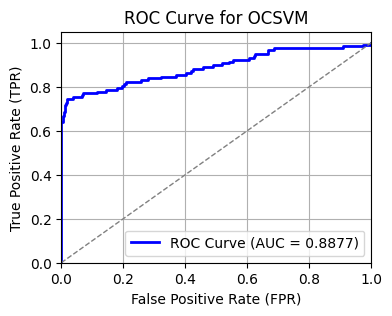

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

decision_scores = ocsvm_model.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(ocsvm_true_labels, -decision_scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for OCSVM')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [ ]:
from joblib import dump
dump(ocsvm_model, r'C:\Users\Asus\Downloads\Thesis\models\model\ocsvm\basic_ocsvm.joblib')

['C:\\Users\\Asus\\Downloads\\Thesis\\models\\model\\ocsvm\\basic_ocsvm.joblib']

### Baseline with SMOTE

In [34]:
# Create a SMOTE object
smote = SMOTE(random_state=42)

# Resample the training set
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Checking the balance
print(y_train_smote.value_counts())

anomaly
0.0    75329
1.0    75329
Name: count, dtype: int64


In [ ]:
ocsvm_model = OneClassSVM(kernel='rbf', gamma='auto', nu=0.01)  # nu is roughly the proportion of outliers

normal_data_train = X_train_smote[y_train_smote == 0]
ocsvm_model.fit(normal_data_train)

OneClassSVM(gamma='auto', nu=0.01)

In [ ]:
ocsvm_predictions = ocsvm_model.predict(X_test)
ocsvm_binary_predictions = [0 if pred == 1 else 1 for pred in ocsvm_predictions]

ocsvm_true_labels = y_test
ocsvm_predicted_labels = ocsvm_binary_predictions
accuracy = accuracy_score(ocsvm_true_labels, ocsvm_predicted_labels)
confusion = confusion_matrix(ocsvm_true_labels, ocsvm_predicted_labels)
precision = precision_score(ocsvm_true_labels, ocsvm_predicted_labels)
recall = recall_score(ocsvm_true_labels, ocsvm_predicted_labels)
f1 = f1_score(ocsvm_true_labels, ocsvm_predicted_labels)

print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Classification Report:")
print(classification_report(ocsvm_true_labels, ocsvm_predicted_labels))

Accuracy: 0.9691
Confusion Matrix:
[[18685   178]
 [  440   697]]
Precision: 0.7965714285714286
Recall: 0.6130167106420404
F1 Score: 0.6928429423459245
Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98     18863
         1.0       0.80      0.61      0.69      1137

    accuracy                           0.97     20000
   macro avg       0.89      0.80      0.84     20000
weighted avg       0.97      0.97      0.97     20000



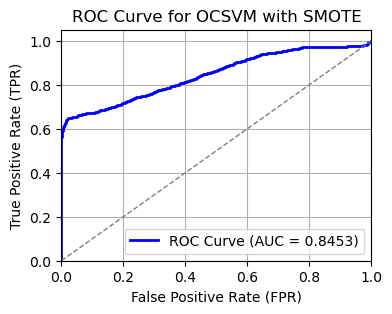

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

decision_scores = ocsvm_model.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(ocsvm_true_labels, -decision_scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for OCSVM with SMOTE')
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Optimization
**Grid Search** (kernel='rbf', gamma='scale', nu=0.1)  
**Random Search** (kernel='poly', gamma='scale', nu=0.42390845139540895)  
**Bayesian** (kernel='poly', gamma='scale', nu=0.44692718648402907)  
**PSO** (gamma_optimal = 0.12157344 nu_optimal = 0.08416075 kernel_type = 'rbf')  
**Hyperband** (gamma=0.0563750769961434, kernel='sigmoid', nu=0.010035039446789056)

### Grid search

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {
    'nu': [0.1, 0.5, 0.7],
    'kernel': ['rbf', 'linear', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 0.5]
}

# Custom scoring function
def custom_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='binary')

scorer = make_scorer(custom_f1, greater_is_better=True)

In [ ]:
# Initialize OCSVM
ocsvm = OneClassSVM()

# Perform Grid Search
grid_search = GridSearchCV(estimator=ocsvm, param_grid=param_grid, scoring=scorer, cv=3, verbose=2)
grid_search.fit(X_train, y_train)

# Best Parameters
print("Best Parameters:", grid_search.best_params_)

# Train the optimized model
best_ocsvm = grid_search.best_estimator_

In [ ]:
gs_ocsvm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.1)

normal_data_train = X_train[y_train == 0]
gs_ocsvm.fit(normal_data_train)

OneClassSVM(nu=0.1)

In [ ]:
ocsvm_predictions = gs_ocsvm.predict(X_test)
ocsvm_binary_predictions = [0 if pred == 1 else 1 for pred in ocsvm_predictions]

ocsvm_true_labels = y_test
ocsvm_predicted_labels = ocsvm_binary_predictions
accuracy = accuracy_score(ocsvm_true_labels, ocsvm_predicted_labels)
confusion = confusion_matrix(ocsvm_true_labels, ocsvm_predicted_labels)
precision = precision_score(ocsvm_true_labels, ocsvm_predicted_labels)
recall = recall_score(ocsvm_true_labels, ocsvm_predicted_labels)
f1 = f1_score(ocsvm_true_labels, ocsvm_predicted_labels)

print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8892
Confusion Matrix:
[[16978  1885]
 [  331   806]]
Precision: 0.2995169082125604
Recall: 0.7088830255057168
F1 Score: 0.4211076280041797


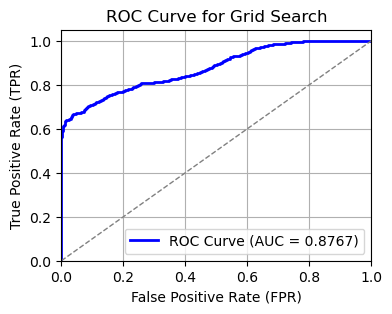

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

decision_scores = gs_ocsvm.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(ocsvm_true_labels, -decision_scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Grid Search')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [ ]:
dump(gs_ocsvm, r'C:\Users\Asus\Downloads\Thesis\models\model\gs_ocsvm.joblib')

['C:\\Users\\Asus\\Downloads\\Thesis\\models\\model\\gs_ocsvm.joblib']

### Random Search

In [ ]:
param_distributions = {
    'nu': uniform(0.01, 0.7),  # Assuming a continuous distribution from 0.01 to 0.7
    'kernel': ['rbf', 'linear', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 0.5]  # You could use a distribution for gamma if needed
}

# Custom scoring function
def custom_f1(y_true, y_pred):
    # Since One-Class SVM outputs -1 and 1, convert them as per your anomaly setup
    y_pred = (y_pred == -1).astype(int)
    return f1_score(y_true, y_pred, average='binary')

scorer = make_scorer(custom_f1, greater_is_better=True)

# Initialize OCSVM
ocsvm = OneClassSVM()

# Perform Randomized Search
random_search = RandomizedSearchCV(estimator=ocsvm, param_distributions=param_distributions, n_iter=50, scoring=scorer, cv=3, verbose=2, random_state=42)
random_search.fit(X_train, y_train)  # Ensure y_train is appropriately formatted for your anomaly detection setup

# Best Parameters
print("Best Parameters:", random_search.best_params_)

# Train the optimized model
best_ocsvm = random_search.best_estimator_

In [ ]:
rs_ocsvm = OneClassSVM(kernel='poly', gamma='scale', nu=0.42390845139540895)

normal_data_train = X_train[y_train == 0]
rs_ocsvm.fit(normal_data_train)

OneClassSVM(kernel='poly', nu=0.42390845139540895)

In [ ]:
ocsvm_predictions = rs_ocsvm.predict(X_test)
ocsvm_binary_predictions = [0 if pred == 1 else 1 for pred in ocsvm_predictions]

ocsvm_true_labels = y_test
ocsvm_predicted_labels = ocsvm_binary_predictions
accuracy = accuracy_score(ocsvm_true_labels, ocsvm_predicted_labels)
confusion = confusion_matrix(ocsvm_true_labels, ocsvm_predicted_labels)
precision = precision_score(ocsvm_true_labels, ocsvm_predicted_labels)
recall = recall_score(ocsvm_true_labels, ocsvm_predicted_labels)
f1 = f1_score(ocsvm_true_labels, ocsvm_predicted_labels)

print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.5951
Confusion Matrix:
[[10948  7915]
 [  183   954]]
Precision: 0.10756567820498365
Recall: 0.8390501319261213
F1 Score: 0.19068558864681193


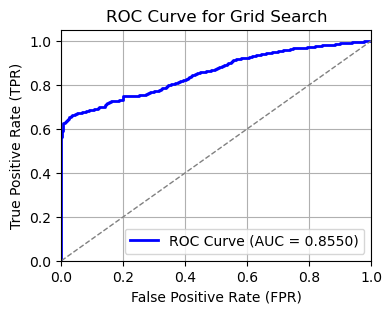

In [ ]:
decision_scores = rs_ocsvm.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(ocsvm_true_labels, -decision_scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Grid Search')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [ ]:
dump(rs_ocsvm, r'C:\Users\Asus\Downloads\Thesis\models\model\ocsvm\rs_ocsvm.joblib')

['C:\\Users\\Asus\\Downloads\\Thesis\\models\\model\\ocsvm\\rs_ocsvm.joblib']

### Bayesian

In [ ]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical
from sklearn.svm import OneClassSVM
from sklearn.metrics import make_scorer, f1_score

In [ ]:
# Define the search space
search_spaces = {
    'nu': Real(0.01, 0.7),  # Range for nu
    'kernel': Categorical(['rbf', 'linear', 'poly']),  # Categorical variables for kernel
    'gamma': Categorical(['scale', 'auto', 0.1, 0.5])  # Gamma settings
}

# Custom scoring function
def custom_f1(y_true, y_pred):
    # Adjust the prediction from {-1, 1} to {0, 1} for anomaly detection
    y_pred = (y_pred == -1).astype(int)
    return f1_score(y_true, y_pred, average='binary')

scorer = make_scorer(custom_f1, greater_is_better=True)

# Initialize the One-Class SVM
ocsvm = OneClassSVM()

# Set up Bayesian optimization
bayes_search = BayesSearchCV(estimator=ocsvm, search_spaces=search_spaces, n_iter=50, scoring=scorer, cv=3, verbose=2, random_state=42)

# Perform the search
bayes_search.fit(df_train, target_train)

# Best Parameters
print("Best Parameters:", bayes_search.best_params_)

# Train the optimized model
best_ocsvm = bayes_search.best_estimator_

In [ ]:
bo_ocsvm = OneClassSVM(kernel='poly', gamma='scale', nu=0.44692718648402907)

normal_data_train = X_train[y_train == 0]
bo_ocsvm.fit(normal_data_train)

OneClassSVM(kernel='poly', nu=0.44692718648402907)

In [41]:
# Function to predict using one model
def predict_with_model(model, data):
    return model.predict(data)  # -1 = anomaly, 1 = normal

In [43]:
# Make predictions with all models in parallel
start_predict_time = time.time()

all_predictions = Parallel(n_jobs=-1)(
    delayed(predict_with_model)(model, X_test) for model in models
)

# Aggregate predictions (e.g., majority voting)
final_predictions = np.sign(np.sum(all_predictions, axis=0))

# Convert predictions to binary labels: -1 -> anomaly (1), 1 -> normal (0)
final_predictions = (final_predictions == -1).astype(int)

end_predict_time = time.time()
prediction_time = end_predict_time - start_predict_time

In [ ]:
ocsvm_predictions = bo_ocsvm.predict(X_test)
ocsvm_binary_predictions = [0 if pred == 1 else 1 for pred in ocsvm_predictions]

ocsvm_true_labels = y_test
ocsvm_predicted_labels = ocsvm_binary_predictions
accuracy = accuracy_score(ocsvm_true_labels, ocsvm_predicted_labels)
confusion = confusion_matrix(ocsvm_true_labels, ocsvm_predicted_labels)
precision = precision_score(ocsvm_true_labels, ocsvm_predicted_labels)
recall = recall_score(ocsvm_true_labels, ocsvm_predicted_labels)
f1 = f1_score(ocsvm_true_labels, ocsvm_predicted_labels)

print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.57565
Confusion Matrix:
[[10541  8322]
 [  165   972]]
Precision: 0.10458360232408005
Recall: 0.8548812664907651
F1 Score: 0.18636755823986195


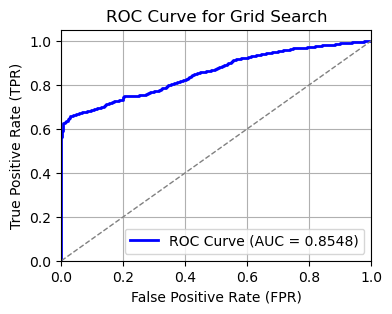

In [ ]:
decision_scores = bo_ocsvm.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(ocsvm_true_labels, -decision_scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Grid Search')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [ ]:
dump(bo_ocsvm, r'C:\Users\Asus\Downloads\Thesis\models\model\ocsvm\bo_ocsvm.joblib')

['C:\\Users\\Asus\\Downloads\\Thesis\\models\\model\\ocsvm\\bo_ocsvm.joblib']

### PSO optimization

In [13]:
from pyswarm import pso
from sklearn.metrics import precision_recall_fscore_support

In [12]:
! pip install pyswarm

  Preparing metadata (setup.py) ... done
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4464 sha256=69ecb717a2c2870b9879f2c291e1ba5fe6473a9b3e18d09f2e76e8425e80685b
  Stored in directory: /root/.cache/pip/wheels/71/67/40/62fa158f497f942277cbab8199b05cb61c571ab324e67ad0d6
Successfully built pyswarm


In [19]:
def save_state(state, filename='pso_state.pkl'):
    with open(filename, 'wb') as f:
        pickle.dump(state, f)

def load_state(filename='pso_state.pkl'):
    try:
        with open(filename, 'rb') as f:
            return pickle.load(f)
    except FileNotFoundError:
        return None  # Return None if no file found

In [20]:
# Define the objective function and include the global variable check and update within it
global_best_params = None
global_best_score = float('inf')

def ocsvm_f1_optimize(params):
    global global_best_params, global_best_score

    ocsvm = OneClassSVM(gamma=params[0], nu=params[1])
    ocsvm.fit(X_train)
    preds = ocsvm.predict(X_test)
    preds = [1 if x == -1 else 0 for x in preds]
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, preds, average='binary')
    weighted_score = -(f1 + 0.5 * precision)

    if weighted_score < global_best_score:
        global_best_score = weighted_score
        global_best_params = params
        save_state({'params': global_best_params, 'score': global_best_score})

    return weighted_score

# Load previous state if it exists
state = load_state()
if state:
    global_best_params = state['params']
    global_best_score = state['score']

# Set bounds and other PSO parameters
lb = [0.0001, 0.01]
ub = [1, 0.5]
xopt, fopt = pso(ocsvm_f1_optimize, lb, ub, swarmsize=10, maxiter=50)

print("Best parameters found:", xopt)
print("Best negative weighted score found:", fopt)

Stopping search: maximum iterations reached --> 50
Best parameters found: [0.12157344 0.08416075]
Best negative weighted score found: -0.9117032178725148


In [6]:
# Best parameters found from PSO
gamma_optimal = 0.12157344
nu_optimal = 0.08416075
kernel_type = 'rbf'


pso_ocsvm = OneClassSVM(kernel=kernel_type, gamma=gamma_optimal, nu=nu_optimal)
normal_data_train = X_train[y_train == 0]
pso_ocsvm.fit(normal_data_train)

OneClassSVM(gamma=0.12157344, nu=0.08416075)

In [7]:
ocsvm_predictions = pso_ocsvm.predict(X_test)
ocsvm_binary_predictions = [0 if pred == 1 else 1 for pred in ocsvm_predictions]

ocsvm_true_labels = y_test
ocsvm_predicted_labels = ocsvm_binary_predictions
accuracy = accuracy_score(ocsvm_true_labels, ocsvm_predicted_labels)
confusion = confusion_matrix(ocsvm_true_labels, ocsvm_predicted_labels)
precision = precision_score(ocsvm_true_labels, ocsvm_predicted_labels)
recall = recall_score(ocsvm_true_labels, ocsvm_predicted_labels)
f1 = f1_score(ocsvm_true_labels, ocsvm_predicted_labels)

print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9026
Confusion Matrix:
[[17264  1599]
 [  349   788]]
Precision: 0.330121491411814
Recall: 0.693051890941073
F1 Score: 0.44721906923950056


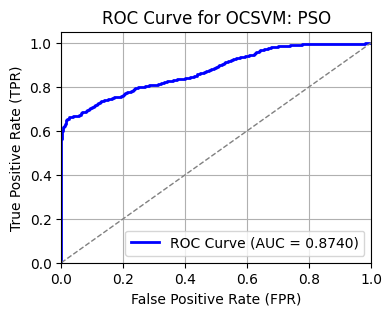

In [41]:
decision_scores = pso_ocsvm.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(ocsvm_true_labels, -decision_scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for OCSVM: PSO')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [8]:
from joblib import dump

dump(pso_ocsvm, r'C:\Users\Asus\Downloads\Thesis\models\model\ocsvm\pso_ocsvm.joblib')

['C:\\Users\\Asus\\Downloads\\Thesis\\models\\model\\ocsvm\\pso_ocsvm.joblib']

### Hyperband Optimization

In [3]:
import optuna

In [248]:
sampled_data = data.sample(n=10000, random_state=42)

In [250]:
X = sampled_data.drop(columns=['anomaly'])
y = sampled_data['anomaly']

In [252]:
# Step 1: Prepare sampled data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [305]:
# Baseline results (replace with your actual baseline metrics)
baseline_f1 = 0.6928
baseline_precision = 0.7965
baseline_recall = 0.613
baseline_auc = 0.8453

In [307]:
def objective(trial):
    # Hyperparameter suggestions
    nu = trial.suggest_float("nu", 0.01, 0.1)  # Proportion of anomalies
    gamma = trial.suggest_loguniform("gamma", 1e-3, 1e-1)  # Kernel coefficient
    kernel = trial.suggest_categorical("kernel", ["rbf", "poly", "sigmoid"])

    # Initialize the One-Class SVM
    model = OneClassSVM(kernel=kernel, gamma=gamma, nu=nu, shrinking=True)
    normal_data_train = X_train[y_train == 0]
    model.fit(normal_data_train)

    # Predict anomalies on the test set
    y_pred = model.predict(X_test)
    y_pred = (y_pred == -1).astype(int)  # Convert to binary (1 = anomaly)

    # Compute metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    # Compare with baseline
    if f1 < baseline_f1:
        return -1  # Penalize trials that perform worse than baseline
    else:
        return 0.4 * f1 + 0.3 * recall + 0.3 * precision  # Reward trials that outperform baseline


In [333]:
# Step 2: Configure Optuna with Hyperband
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.HyperbandPruner(min_resource=10, max_resource=50)
)

# Step 3: Run the optimization
study.optimize(objective, n_trials=300, n_jobs=-1, timeout=3600)

# Step 4: Display the best parameters and comparison with baseline
best_params = study.best_params
print("Best hyperparameters:", best_params)

[I 2024-12-01 03:09:46,808] A new study created in memory with name: no-name-67ce28f8-2521-400f-872b-06ffbcaf8663
C:\Users\azad.aliyev\AppData\Local\Temp\ipykernel_16688\3042600700.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform("gamma", 1e-3, 1e-1)  # Kernel coefficient
C:\Users\azad.aliyev\AppData\Local\Temp\ipykernel_16688\3042600700.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform("gamma", 1e-3, 1e-1)  # Kernel coefficient
C:\Users\azad.aliyev\AppData\Local\Temp\ipykernel_16688\3042600700.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0

Best hyperparameters: {'nu': 0.010035039446789056, 'gamma': 0.0563750769961434, 'kernel': 'sigmoid'}


In [39]:
#best_params = study.best_params
best_model = OneClassSVM(kernel='sigmoid', gamma=0.0563750769961434, nu=0.010035039446789056, shrinking=True)
normal_data_train = X_train[y_train == 0]
best_model.fit(normal_data_train)

OneClassSVM(gamma=0.0563750769961434, kernel='sigmoid', nu=0.010035039446789056)

In [335]:
best_params = study.best_params
best_model = OneClassSVM(kernel=best_params['kernel'], gamma=best_params['gamma'], nu=best_params['nu'], shrinking=True)
normal_data_train = X_train[y_train == 0]
best_model.fit(normal_data_train)

OneClassSVM(gamma=0.0563750769961434, kernel='sigmoid', nu=0.010035039446789056)

In [37]:
sampled_data = data.sample(n=10000, random_state=42)

X = sampled_data.drop(columns=['anomaly'])
y = sampled_data['anomaly']

# Step 1: Prepare sampled data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [40]:
# Step 7: Evaluate the final model on the test set
y_pred = best_model.predict(X_test)
y_pred = [0 if pred == 1 else 1 for pred in y_pred]

# Compute evaluation metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy===>: {accuracy:.4f}")
print("Final Model Performance:")
print(f"Precision 0.7677===>: {precision:.4f}")
print(f"Recall 0.6496===>: {recall:.4f}")
print(f"F1 Score 0.7037===>: {f1:.4f}")
print(f"AUC 0.8453===>: {auc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy===>: 0.9735
Final Model Performance:
Precision 0.7677===>: 0.8265
Recall 0.6496===>: 0.6923
F1 Score 0.7037===>: 0.7535
AUC 0.8453===>: 0.8416
Confusion Matrix:
[[1866   17]
 [  36   81]]


In [319]:
from joblib import dump
dump(best_model, r'C:\Users\azad.aliyev\Downloads\hb_ocsvm.joblib')

['C:\\Users\\azad.aliyev\\Downloads\\hb_ocsvm.joblib']

## Data Splitting

In [14]:
from joblib import load

ocsvm = load(r'C:\Users\Asus\Downloads\Thesis\models\model\ocsvm\hb_ocsvm.joblib')

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator OneClassSVM from version 1.5.1 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### 70/30 Splitting

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (7000, 20)
Test data shape: (3000, 20)


In [16]:
ocsvm_predictions = ocsvm.predict(X_test)
ocsvm_binary_predictions = [0 if pred == 1 else 1 for pred in ocsvm_predictions]

ocsvm_true_labels = y_test
ocsvm_predicted_labels = ocsvm_binary_predictions
accuracy = accuracy_score(ocsvm_true_labels, ocsvm_predicted_labels)
confusion = confusion_matrix(ocsvm_true_labels, ocsvm_predicted_labels)
precision = precision_score(ocsvm_true_labels, ocsvm_predicted_labels)
recall = recall_score(ocsvm_true_labels, ocsvm_predicted_labels)
f1 = f1_score(ocsvm_true_labels, ocsvm_predicted_labels)

print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9733333333333334
Confusion Matrix:
[[2794   23]
 [  57  126]]
Precision: 0.8456375838926175
Recall: 0.6885245901639344
F1 Score: 0.7590361445783133


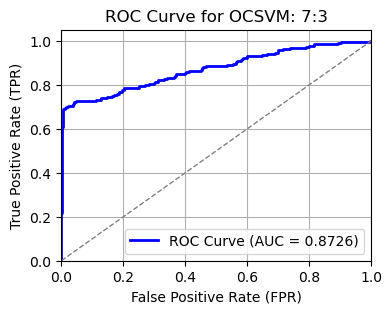

In [17]:
decision_scores = ocsvm.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(ocsvm_true_labels, -decision_scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for OCSVM: 7:3')
plt.legend(loc="lower right")
plt.grid()
plt.show()

### 90/10 Test Splitting

In [20]:
X_train = X.iloc[:9000, :]
X_test = X.iloc[9000:, :]
y_train = y.iloc[:9000]
y_test = y.iloc[9000:]

In [21]:
ocsvm_predictions = ocsvm.predict(X_test)
ocsvm_binary_predictions = [0 if pred == 1 else 1 for pred in ocsvm_predictions]

ocsvm_true_labels = y_test
ocsvm_predicted_labels = ocsvm_binary_predictions
accuracy = accuracy_score(ocsvm_true_labels, ocsvm_predicted_labels)
confusion = confusion_matrix(ocsvm_true_labels, ocsvm_predicted_labels)
precision = precision_score(ocsvm_true_labels, ocsvm_predicted_labels)
recall = recall_score(ocsvm_true_labels, ocsvm_predicted_labels)
f1 = f1_score(ocsvm_true_labels, ocsvm_predicted_labels)

print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.974
Confusion Matrix:
[[941   7]
 [ 19  33]]
Precision: 0.825
Recall: 0.6346153846153846
F1 Score: 0.717391304347826


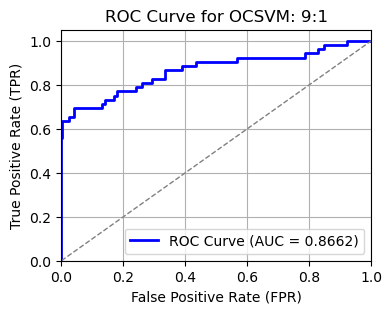

In [22]:
decision_scores = ocsvm.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(ocsvm_true_labels, -decision_scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for OCSVM: 9:1')
plt.legend(loc="lower right")
plt.grid()
plt.show()

### 60/40 Test Splitting

In [23]:
X_train = X.iloc[:6000, :]
X_test = X.iloc[6000:, :]
y_train = y.iloc[:6000]
y_test = y.iloc[6000:]

In [24]:
ocsvm_predictions = ocsvm.predict(X_test)
ocsvm_binary_predictions = [0 if pred == 1 else 1 for pred in ocsvm_predictions]

ocsvm_true_labels = y_test
ocsvm_predicted_labels = ocsvm_binary_predictions
accuracy = accuracy_score(ocsvm_true_labels, ocsvm_predicted_labels)
confusion = confusion_matrix(ocsvm_true_labels, ocsvm_predicted_labels)
precision = precision_score(ocsvm_true_labels, ocsvm_predicted_labels)
recall = recall_score(ocsvm_true_labels, ocsvm_predicted_labels)
f1 = f1_score(ocsvm_true_labels, ocsvm_predicted_labels)

print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.97375
Confusion Matrix:
[[3741   38]
 [  67  154]]
Precision: 0.8020833333333334
Recall: 0.6968325791855203
F1 Score: 0.7457627118644069


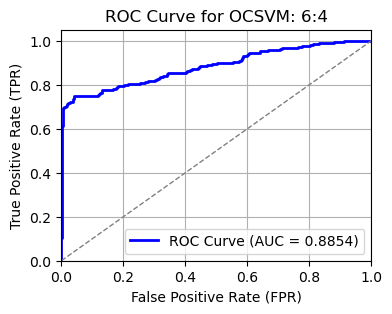

In [25]:
decision_scores = ocsvm.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(ocsvm_true_labels, -decision_scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for OCSVM: 6:4')
plt.legend(loc="lower right")
plt.grid()
plt.show()

### k-fold cross validation

In [29]:
sampled_data = data.sample(n=10000, random_state=42)
X = sampled_data.drop(columns=['anomaly'])
y = sampled_data['anomaly']

In [11]:
from sklearn.model_selection import StratifiedKFold

In [32]:
ocsvm_gs = load(r'C:\Users\Asus\Downloads\Thesis\models\model\ocsvm\gs_ocsvm.joblib')
ocsvm_pso = load(r'C:\Users\Asus\Downloads\Thesis\models\model\ocsvm\pso_ocsvm.joblib')
ocsvm_rs = load(r'C:\Users\Asus\Downloads\Thesis\models\model\ocsvm\rs_ocsvm.joblib')
ocsvm_bo = load(r'C:\Users\Asus\Downloads\Thesis\models\model\ocsvm\bo_ocsvm.joblib')
ocsvm_hb = load(r'C:\Users\Asus\Downloads\Thesis\models\model\ocsvm\hb_ocsvm.joblib')
# ocsvm_de = load(r'C:\Users\Asus\Downloads\Thesis\models\model\ocsvm\de_ocsvm.joblib')

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator OneClassSVM from version 1.5.1 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [33]:
# Assuming `ocsvm_model_1` and `ocsvm_model_2` are your loaded OCSVM models
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

auc_scores_model_1 = []
auc_scores_model_2 = []
auc_scores_model_3 = []
auc_scores_model_4 = []
auc_scores_model_5 = []
auc_scores_model_6 = []


for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # PSO
    ocsvm_pso.fit(X_train)
    scores_model_1 = ocsvm_pso.decision_function(X_test)
    scores_model_1 = -scores_model_1  # Adjust if necessary
    fpr_1, tpr_1, _ = roc_curve(y_test, scores_model_1)
    auc_scores_model_1.append(auc(fpr_1, tpr_1))

    # Grid
    ocsvm_gs.fit(X_train)
    scores_model_2 = ocsvm_gs.decision_function(X_test)
    scores_model_2 = -scores_model_2  # Adjust if necessary
    fpr_2, tpr_2, _ = roc_curve(y_test, scores_model_2)
    auc_scores_model_2.append(auc(fpr_2, tpr_2))
    
    # Random
    ocsvm_rs.fit(X_train)
    scores_model_3 = ocsvm_rs.decision_function(X_test)
    scores_model_3 = -scores_model_3  # Adjust if necessary
    fpr_3, tpr_3, _ = roc_curve(y_test, scores_model_3)
    auc_scores_model_3.append(auc(fpr_3, tpr_3))

    # Bayesian
    ocsvm_bo.fit(X_train)
    scores_model_4 = ocsvm_bo.decision_function(X_test)
    scores_model_4 = -scores_model_4  # Adjust if necessary
    fpr_4, tpr_4, _ = roc_curve(y_test, scores_model_4)
    auc_scores_model_4.append(auc(fpr_4, tpr_4))

    # Hyperband
    ocsvm_hb.fit(X_train)
    scores_model_5 = ocsvm_hb.decision_function(X_test)
    scores_model_5 = -scores_model_5  # Adjust if necessary
    fpr_5, tpr_5, _ = roc_curve(y_test, scores_model_5)
    auc_scores_model_5.append(auc(fpr_5, tpr_5))

#     # Differential Evolution
#     ocsvm_de.fit(X_train)
#     scores_model_6 = ocsvm_de.decision_function(X_test)
#     scores_model_6 = -scores_model_6  # Adjust if necessary
#     fpr_6, tpr_6, _ = roc_curve(y_test, scores_model_6)
#     auc_scores_model_6.append(auc(fpr_6, tpr_6))

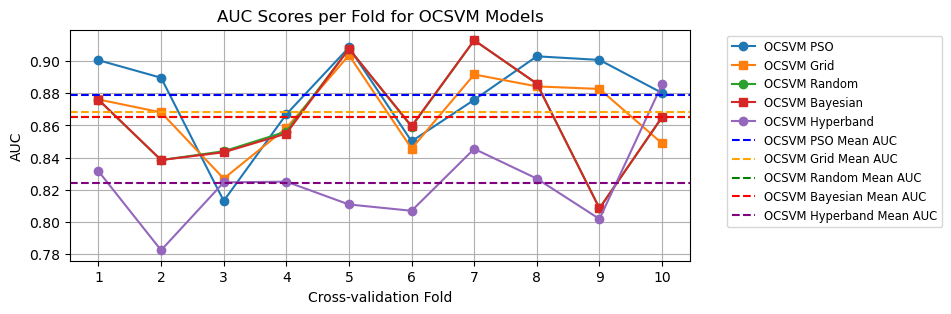

In [34]:
# Plotting AUC scores for both models
plt.figure(figsize=(8, 3))
folds = list(range(1, len(auc_scores_model_1) + 1))

plt.plot(folds, auc_scores_model_1, marker='o', label='OCSVM PSO')
plt.plot(folds, auc_scores_model_2, marker='s', label='OCSVM Grid')
plt.plot(folds, auc_scores_model_3, marker='o', label='OCSVM Random')
plt.plot(folds, auc_scores_model_4, marker='s', label='OCSVM Bayesian')
plt.plot(folds, auc_scores_model_5, marker='o', label='OCSVM Hyperband')
# plt.plot(folds, auc_scores_model_6, marker='s', label='OCSVM Differential Evo')



# Add mean AUC as horizontal lines
plt.axhline(np.mean(auc_scores_model_1), color='blue', linestyle='--', label='OCSVM PSO Mean AUC')
plt.axhline(np.mean(auc_scores_model_2), color='orange', linestyle='--', label='OCSVM Grid Mean AUC')
plt.axhline(np.mean(auc_scores_model_3), color='green', linestyle='--', label='OCSVM Random Mean AUC')
plt.axhline(np.mean(auc_scores_model_4), color='red', linestyle='--', label='OCSVM Bayesian Mean AUC')
plt.axhline(np.mean(auc_scores_model_5), color='purple', linestyle='--', label='OCSVM Hyperband Mean AUC')
# plt.axhline(np.mean(auc_scores_model_6), color='grey', linestyle='--', label='OCSVM Differential Evo Mean AUC')



plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

plt.xlabel('Cross-validation Fold')
plt.ylabel('AUC')
plt.title('AUC Scores per Fold for OCSVM Models')
plt.xticks(folds)
plt.grid(True)
plt.show()

### AUC Curve per data split

In [26]:
split_ratios = ['7:3', '6:4', '9:1', '8:2']
auc_scores = [0.8726, 0.8854, 0.8662, 0.8740]

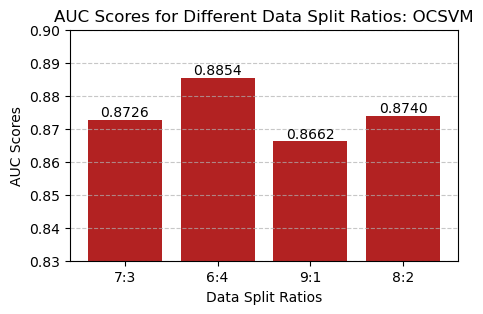

In [27]:
# Creating the plot
plt.figure(figsize=(5, 3))
plt.bar(split_ratios, auc_scores, color='firebrick')

# Adding titles and labels
plt.xlabel('Data Split Ratios')
plt.ylabel('AUC Scores')
plt.title('AUC Scores for Different Data Split Ratios: OCSVM')
plt.ylim([0.83, 0.9])  # Adjust the y-axis limits to make differences more visible

# Adding the AUC scores on top of each bar for clarity
for i in range(len(auc_scores)):
    plt.text(i, auc_scores[i] + 0.001, f'{auc_scores[i]:.4f}', ha = 'center', color = 'black')

# Show the plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Time computation

In [15]:
import time

In [74]:
sampled_data = data.sample(n=300000, random_state=42)

In [76]:
X = sampled_data.drop(columns=['anomaly'])
y = sampled_data['anomaly']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (240000, 20)
Test data shape: (60000, 20)


In [78]:
ocsvm_model = OneClassSVM(kernel='rbf', gamma='auto', nu=0.01)  # nu is roughly the proportion of outliers

start_time = time.time()

normal_data_train = X_train[y_train == 0]
ocsvm_model.fit(normal_data_train)

# End time
end_time = time.time()
# Calculate elapsed time
elapsed_time = end_time - start_time

In [79]:
print(f"Computational Time: {elapsed_time:.4f} seconds.")
print("Trained data shape:", X_train.shape)

Computational Time: 545.6752 seconds.
Trained data shape: (240000, 20)


#### paralelization

In [83]:
# Function to train OCSVM on a data chunk
def train_ocsvm_on_chunk(data_chunk, gamma, nu):
    model = OneClassSVM(kernel="rbf", gamma=gamma, nu=nu)
    model.fit(data_chunk)
    return model
    
# ocsvm_model = OneClassSVM(kernel='rbf', gamma='auto', nu=0.01)  # nu is roughly the proportion of outliers

In [85]:
# Split the dataset into chunks (e.g., 4 chunks)
chunks = np.array_split(X_train, 8)  # Replace 4 with the number of cores you want to use

# Start time
start_time = time.time()

# Train models in parallel
models = Parallel(n_jobs=-1)(
    delayed(train_ocsvm_on_chunk)(chunk, gamma='auto', nu=0.01) for chunk in chunks)

# End time
end_time = time.time()
# Calculate elapsed time
elapsed_time = end_time - start_time


C:\Users\azad.aliyev\AppData\Local\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [87]:
print(f"Trained {len(models)} OCSVM models in parallel.")
print(f"Computational Time: {elapsed_time:.4f} seconds.")
print("Trained data shape:", X_train.shape)

Trained 8 OCSVM models in parallel.
Computational Time: 14.4010 seconds.
Trained data shape: (240000, 20)


#### Full data

In [17]:
X = data.drop(columns=['anomaly'])
y = data['anomaly']

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (743118, 20)
Test data shape: (185780, 20)


In [56]:
ocsvm_model = OneClassSVM(kernel='rbf', gamma='auto', nu=0.01)  # nu is roughly the proportion of outliers

start_time = time.time()

normal_data_train = X_train[y_train == 0]
ocsvm_model.fit(normal_data_train)

# End time
end_time = time.time()
# Calculate elapsed time
elapsed_time = end_time - start_time

In [58]:
print(f"Computational Time: {elapsed_time:.4f} seconds.")
print("Trained data shape:", X_train.shape)

Computational Time: 7042.7727 seconds.
Trained data shape: (743118, 20)


In [60]:
start_predict_time=time.time()
ocsvm_predictions=ocsvm_model.predict(X_test)
end_predict_time=time.time()
prediction_time=end_predict_time-start_predict_time

In [61]:
print(f"Computational Time: {prediction_time:.4f} seconds.")

Computational Time: 72.2293 seconds.


#### Paralelization implemented

In [21]:
import numpy as np
from sklearn.svm import OneClassSVM
from joblib import Parallel, delayed

In [25]:
# Function to train OCSVM on a data chunk
def train_ocsvm_on_chunk(data_chunk, gamma, nu):
    model = OneClassSVM(kernel="rbf", gamma=gamma, nu=nu)
    model.fit(data_chunk)
    return model
    
# ocsvm_model = OneClassSVM(kernel='rbf', gamma='auto', nu=0.01)  # nu is roughly the proportion of outliers

In [31]:
# Split the dataset into chunks (e.g., 4 chunks)
chunks = np.array_split(X_train, 8)  # Replace 4 with the number of cores you want to use

C:\Users\azad.aliyev\AppData\Local\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [33]:
# Start time
start_time = time.time()

# Train models in parallel
models = Parallel(n_jobs=-1)(
    delayed(train_ocsvm_on_chunk)(chunk, gamma='auto', nu=0.01) for chunk in chunks
)

# End time
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

In [35]:
print(f"Trained {len(models)} OCSVM models in parallel.")
print(f"Computational Time: {elapsed_time:.4f} seconds.")
print("Trained data shape:", X_train.shape)

Trained 8 OCSVM models in parallel.
Computational Time: 159.2417 seconds.
Trained data shape: (743118, 20)


In [45]:
print(f"Prediction time: {prediction_time:.4f} seconds")

Prediction time: 97.4588 seconds


In [49]:
print(f"Prediction time: {prediction_time:.4f} seconds")

Prediction time: 14.5414 seconds
